<h1><center>
    ECE 438 - Laboratory 8<br/>
    Number Representation and Waveform Quantization<br/>
    <small>Last Updated on May 5, 2022</small>
</center></h1>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import IPython.display as ipd
from helper import xcorr, lloyds

In [2]:
# make sure the plot is displayed in this notebook
%matplotlib inline
# specify the size of the plot
plt.rcParams['figure.figsize'] = (16, 6)

# for auto-reloading extenrnal modules
%load_ext autoreload
%autoreload 2

<h2 style="color:salmon;"><left>1. Introduction</left></h2>

This lab presents two important concepts for working with digital signals. The first section discusses how numbers are stored in memory. Numbers may be either in fixed point or floating point format. Integers are often represented with fixed point format. Decimals, and numbers that may take on a very large range of values would use floating point. The second issue of numeric storage is quantization. All analog signals that are processed on the computer must first be quantized. We will examine the errors that arise from this operation, and determine how different levels of quantization affect a signal’s quality. We will also look at two types of quantizers. The **uniform quantizer** is the simpler of the two. The **max quantizer** is optimal, in that it minimizes the mean square error between the original and quantized signals.

<h2 style="color:salmon;"><left>2. Review of Number Representations</left></h2>

There are two types of numbers that a computer can represent: integers and decimals. These two numbers are stored quite differently in memory. Integers (e.g., $27$, $0$, $-986$) are usually stored in fixed point format, while decimals (e.g., $12.34$, $-0.98$) most often use floating point format. Most integer representations use four bytes of memory; floating point values usually require eight.

There are different conventions for encoding fixed point binary numbers because of the different ways of representing negative numbers. Three types of fixed point formats that accommodate negative integers are **sign-magnitude**, **one’s-complement**, and **two’s-complement**. In all three of these “signed” formats, the first bit denotes the sign of the number: $0$ for positive, and $1$ for negative. For positive numbers, the magnitude simply follows the first bit. Negative numbers are handled differently for each format.

Of course, there is also an **unsigned** data type which can be used when the numbers are known to be non-negative. This allows a greater range of possible numbers since a bit isn’t wasted on the negative sign.

<h3 style="color:salmon;"><left>2.1. Sign-magnitude Representation</left></h3>

Sign-magnitude notation is the simplest way to represent negative numbers. The magnitude of the negative number follows the first bit. If an integer was stored as one byte, the range of possible numbers would be $-127$ to $127$.

The value $+27$ would be represented as

\begin{equation}
    \mathtt{0\quad0\quad0\quad1\quad1\quad0\quad1\quad1}
\end{equation}

The value $-27$ would be represented as

\begin{equation}
    \mathtt{1\quad0\quad0\quad1\quad1\quad0\quad1\quad1}
\end{equation}

<h3 style="color:salmon;"><left>2.2. One's-complement</left></h3>

To represent a negative number, the complement of the bits for the positive number with the same magnitude are computed. The positive number $27$ in one’s-complement form would be written as

\begin{equation}
    \mathtt{0\quad0\quad0\quad1\quad1\quad0\quad1\quad1}
\end{equation}

but the value $-27$ would represented as

\begin{equation}
    \mathtt{1\quad1\quad1\quad0\quad0\quad1\quad0\quad0}
\end{equation}

<h3 style="color:salmon;"><left>2.3. Two's-complement</left></h3>

The problem with each of the above notations is that two different values represent zero Two’s-complement notation is a revision to one’s-complement that solves this problem. To form negative numbers, the positive number is subtracted from a certain binary number. This number has a one in the most significant bit (MSB), followed by as many zeros as there are bits in the representation. If $27$ was represented by an eight-bit integer, $-27$ would be represented as:

\begin{align*}
    \mathtt{1\quad0\quad0\quad0\quad0\quad0\quad0\quad0\quad0}&\\
    -\mathtt{\quad0\quad0\quad0\quad1\quad1\quad0\quad1\quad1}&\\
    =\quad\quad\mathtt{1\quad1\quad1\quad0\quad0\quad1\quad0\quad1}&
\end{align*}

Notice that this result is one plus the one’s-complement representation for $-27$ (modulo-2 addition). What about the second value of 0? That representation is

\begin{equation}
    \mathtt{1\quad0\quad0\quad0\quad0\quad0\quad0\quad0}
\end{equation}

This value equals $-128$ in two’s-complement notation!

\begin{align*}
    \mathtt{1\quad0\quad0\quad0\quad0\quad0\quad0\quad0\quad0}&\\
    -\mathtt{\quad1\quad0\quad0\quad0\quad0\quad0\quad0\quad0}&\\
    =\quad\quad\mathtt{1\quad0\quad0\quad0\quad0\quad0\quad0\quad0}&
\end{align*}

The value represented here is $-128$; we know it is negative, because the result has a $1$ in the MSB. Two’s-complement is used because it can represent one extra negative value. More importantly, if the sum of a series of two’s-complement numbers is within the range, overflows that occur during the summation will not affect the final answer! The range of an $8$-bit two’s complement integer is $[-128,127]$.

<h3 style="color:salmon;"><left>2.4. Floating Point</left></h3>

Floating point notation is used to represent a much wider range of numbers. The tradeoff is that the resolution is variable: it decreases as the magnitude of the number increases. In the fixed point examples above, the resolution was fixed at $1$. It is possible to represent decimals with fixed point notation, but for a fixed word length any increase in resolution is matched by a decrease in the range of possible values.

A floating point number, $F$, has two parts: a **mantissa**, $M$, and an **exponent**, $E$.

\begin{equation}
    F=M*2^E
\end{equation}

The mantissa is a signed fraction, which has a power of two in the denominator. The exponent is a signed integer, which represents the power of two that the mantissa must be multiplied by. These signed numbers may be represented with any of the three fixed-point number formats. The IEEE has a standard for floating point numbers (IEEE 754). For a $32$-bit number, the first bit is the mantissa’s sign. The exponent takes up the next $8$ bits ($1$ for the sign, $7$ for the quantity), and the mantissa is contained in the remaining $23$ bits. The range of values for this number is $(−1.18\times10^{−38},3.40\times10^{38})$.

To add two floating point numbers, the exponents must be the same. If the exponents are different, the mantissa is adjusted until the exponents match. If a very small number is added to a large one, the result may be the same as the large number! For instance, if $0.15600\cdots0\times2^{30}$ is added to $0.62500\cdots0\times2^{-3}$, the second number would be converted to $0.0000\cdots0\times2^{30}$ before addition. Since the mantissa only holds $23$ binary digits, the decimal digits $625$ would be lost in the conversion. In short, the second number is rounded down to zero. For multiplication, the two exponents are added and the mantissas multiplied.

<h2 style="color:salmon;"><left>3. Quantization</left></h2>

<h3 style="color:salmon;"><left>3.1. Introduction</left></h3>

Quantization is the act of rounding off the value of a signal or quantity to certain discrete levels. For example, digital scales may round off weight to the nearest gram. Analog voltage signals in a control system may be rounded off to the nearest volt before they enter a digital controller. Generally, all numbers need to be quantized before they can be represented in a computer.

Digital images are also quantized. The gray levels in a black and white photograph must be quantized in order to store an image in a computer. The “brightness” of the photo at each pixel is assigned an integer value between $0$ and $255$ (typically), where $0$ corresponds to black, and $255$ to white. Since an $8$-bit number can represent $256$ different values, such an image is called an “$8$-bit grayscale” image. An image which is quantized to just $1$ bit per pixel (in other words only black and white pixels) is called a halftone image. Many printers work by placing, or not placing, a spot of colorant on the paper at each point. To accommodate this, an image must be halftoned before it is printed.

Quantization can be thought of as a functional mapping $y = f(x)$ of a real-valued input to a discrete-valued output. An example of a quantization function is shown in Figure 1, where the $x$-axis is the input value, and the $y$-axis is the quantized output value.

<figure>
    <img src="imgs/figure1.png" style="width:60%">
    <em><center>Figure 1: Input-output relation for a $7$-level uniform quantizer</center></em>
</figure>

<h3 style="color:salmon;"><left>3.2. Quantization and Compression</left></h3>

Quantization is sometimes used for compression. As an example, suppose we have a digital image which is represented by 8 different gray levels: $[0, 31, 63, 95, 159, 191, 223, 255]$. To directly store each of the image values, we need at least 8-bits for each pixel since the values range from $0$ to $255$. However, since the image only takes on 8 different values, we can assign a different $3$-bit integer (a code) to represent each pixel: $[000,001,\dots,111]$. Then, instead of storing the actual gray levels, we can store the $3$-bit code for each pixel. A look-up table, possibly stored at the beginning of the file, would be used to decode the image. This lowers the cost of an image considerably: less hard drive space is needed, and less bandwidth is required to transmit the image (i.e. it downloads quicker). In practice, there are much more sophisticated methods of compressing images which rely on quantization.

<h3 style="color:red;"><left>Exercise 3.3: Image Quantization</left></h3>

In the current folder, there is an image file named `fountainbw.tif`, which contains an 8-bit grayscale image.  We will investigate what happens when we quantize it to fewer bits per pixel (b/pel).

**1. Load the image and display it using the following sequence of commands.**

```python
image = plt.imread("fountainbw.tif")
plt.imshow(image, cmap='gray', vmin=0, vmax=255)
plt.axis('image')
plt.show()
```

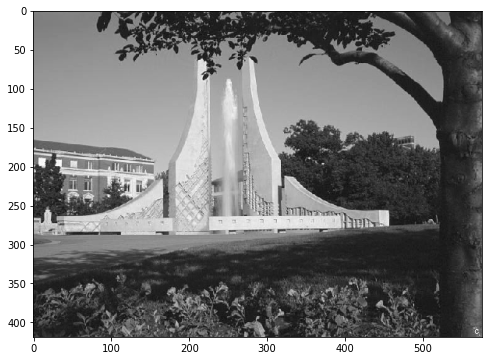

In [6]:
image = plt.imread("fountainbw.tif")
plt.imshow(image, cmap='gray', vmin=0, vmax=255) # cmap specifies the colormap of the image
plt.axis('image')
plt.show()

---

The image array will initially be of type *uint8*, so you will need to convert the image matrix to type `float` before performing any computation. Use the following command for this:

```python
image = image.astype(float)
```

**2. Print the data type of this image, then convert the image matrix to type `float`, and print the data type of this image again.**

* Use `image.dtype` to get the data type of `image`.

In [7]:
print("The image array is of type {}.".format(image.dtype))
image = image.astype(float)
print("The image array is now of type {}.".format(image.dtype))

The image array is of type uint8.
The image array is now of type float64.


---

There is an easy way to uniformly quantize a signal. Let

\begin{equation}
    \Delta=\frac{\max X-\min X}{N - 1}
\end{equation}

where $X$ is the signal to be quantized, and $N$ is the number of quantization levels. To force data to have a uniform quantization step of $\Delta$,

* subtract $\min X$ from the data and divide the result by $\Delta$.
* round the data to the nearest integer.
* multiply the rounded data by $\Delta$ and add $\min X$ to convert the data back to its original scale.

**3. Complete the function below which will uniformly quantize an input array ```X``` (either a vector or a matrix) to an ```numBits```-bit array.**

In [ ]:
def Uquant(X, numBits):
    """
    Parameters
    ---
    X: the input array to be quantized
    numBits: the number of bits. The number of quantization levels will be 2^numBits.
    
    Returns
    ---
    Y: the quantized array
    """
    
    Y = None
    return Y

In [8]:
def Uquant(X, numBits):
    N = 2 ** numBits
    delta = (np.max(X) - np.min(X)) / (N - 1)
    Y = np.round((X - np.min(X)) / delta) * delta + np.min(X)
    return Y

**4. Use this function to quantize the fountain image to $7$, $6$, $5$, $4$, $3$, $2$, $1$ b/pel, and display and observe the output images. Don't forget the titles of the images.**

* To display a grayscale image `image`, use the following commands:
```python
plt.imshow(image.astype(np.uint8), cmap='gray', vmin=0, vmax=255)
plt.title("title")
plt.show()
```

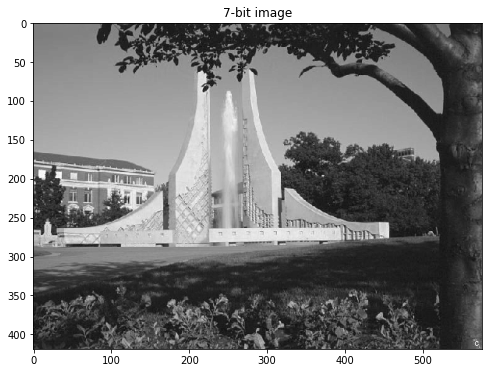

In [12]:
plt.imshow(Uquant(image, 7).astype(np.uint8), cmap='gray', vmin=0, vmax=255)
plt.title("7-bit image")
plt.show()

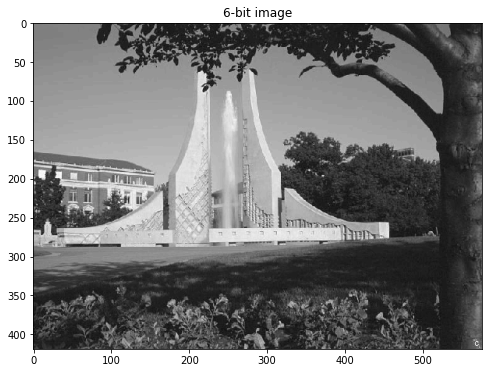

In [13]:
plt.imshow(Uquant(image, 6).astype(np.uint8), cmap='gray', vmin=0, vmax=255)
plt.title("6-bit image")
plt.show()

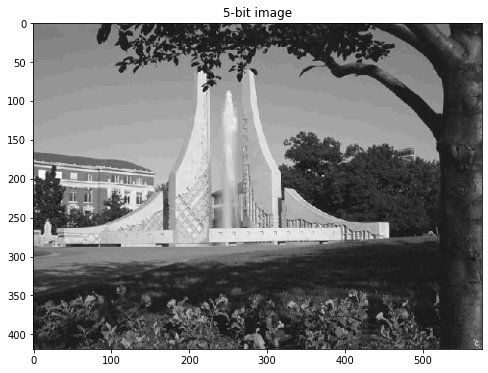

In [14]:
plt.imshow(Uquant(image, 5).astype(np.uint8), cmap='gray', vmin=0, vmax=255)
plt.title("5-bit image")
plt.show()

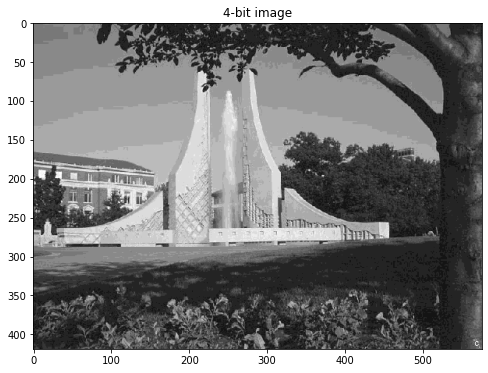

In [15]:
plt.imshow(Uquant(image, 4).astype(np.uint8), cmap='gray', vmin=0, vmax=255)
plt.title("4-bit image")
plt.show()

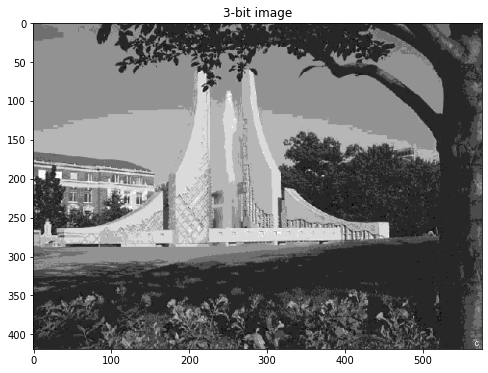

In [16]:
plt.imshow(Uquant(image, 3).astype(np.uint8), cmap='gray', vmin=0, vmax=255)
plt.title("3-bit image")
plt.show()

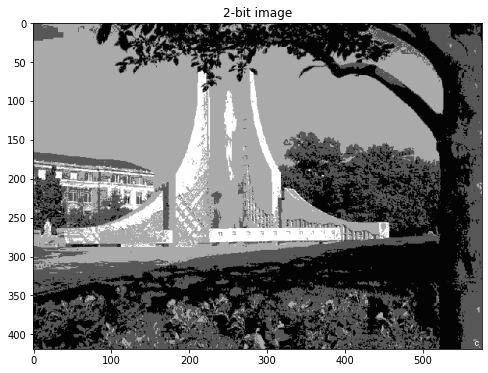

In [17]:
plt.imshow(Uquant(image, 2).astype(np.uint8), cmap='gray', vmin=0, vmax=255)
plt.title("2-bit image")
plt.show()

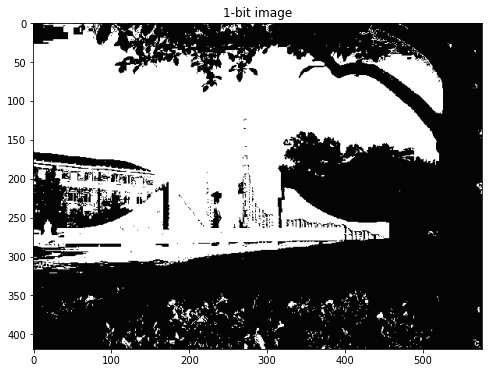

In [18]:
plt.imshow(Uquant(image, 1).astype(np.uint8), cmap='gray', vmin=0, vmax=255)
plt.title("1-bit image")
plt.show()

**5. Describe the artifacts (errors) that appear in the image as the number of bits is lowered.**

insert your answer here

**6. Note the number of b/pel at which the image quality noticeably deteriorates.**

insert your answer here

**7. Compare each of four quantized images ($7$, $4$, $2$ and $1$ b/per) to the original.**

insert your answer here

<h3 style="color:red;"><left>Exercise 3.4: Audio Quantization</left></h3>

If an audio signal is to be coded, either for compression or for digital transmission, it must undergo some form of quantization. Most often, a general technique known as **vector quantization** is employed for this task, but this technique must be tailored to the specific application so it will not be addressed here. In this exercise, we will observe the effect of uniformly quantizing the samples of two audio signals.

**1. Use your function `Uquant()` to quantize each of these signals: ```speech.au``` and ```music.au``` to 7, 4, 2 and 1 bits/sample. Listen to the original and quantized signals.**

* To read an audio file:
```python
speech, fs = sf.read("speech.au")  # speech is the signal vector, and fs is the sampling frequency
```
* To play a signal
```python
ipd.Audio(speech, rate=fs)
```

In [19]:
speech, fs = sf.read("speech.au")
ipd.Audio(speech, rate=fs)

In [20]:
speech7 = Uquant(speech, 7)
ipd.Audio(speech7, rate=fs)

In [21]:
speech4 = Uquant(speech, 4)
ipd.Audio(speech4, rate=fs)

In [22]:
speech2 = Uquant(speech, 2)
ipd.Audio(speech2, rate=fs)

In [23]:
speech1 = Uquant(speech, 1)
ipd.Audio(speech1, rate=fs)

In [24]:
music, fs = sf.read("music.au")
ipd.Audio(music, rate=fs)

In [25]:
music7 = Uquant(music, 7)
ipd.Audio(music7, rate=fs)

In [26]:
music4 = Uquant(music, 4)
ipd.Audio(music4, rate=fs)

In [27]:
music2 = Uquant(music, 2)
ipd.Audio(music2, rate=fs)

In [28]:
music1 = Uquant(music, 1)
ipd.Audio(music1, rate=fs)

**2. For each signal, describe the change in quality as the number of b/sample is reduced.**

insert your answer here

**3. For each signal, is there a point at which the signal quality deteriorates drastically? At what point (if any) does it become incomprehensible?**

insert your answer here

**4. Which signal’s quality deteriorates faster as the number of levels decreases?**

insert your answer here

**5. Do you think 4 b/sample is acceptable for telephone systems? What about 2 b/sample?**

insert your answer here

**6. Plot the four quantized `speech` signals over the index range $[7200:7400)$. Generate a similar figure for the `music` signal, using the same indices.**

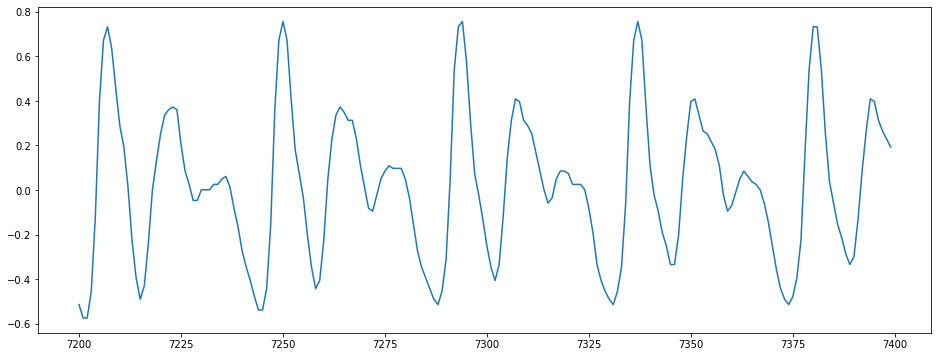

In [29]:
plt.plot(np.arange(7200, 7400, 1), speech7[7200:7400])
plt.show()

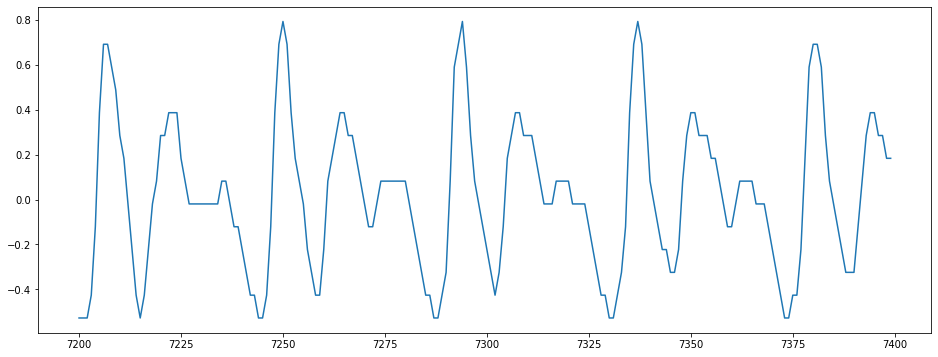

In [30]:
plt.plot(np.arange(7200, 7400, 1), speech4[7200:7400])
plt.show()

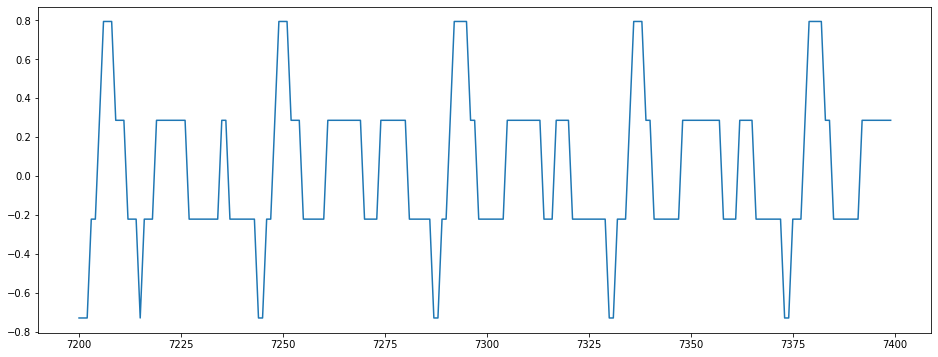

In [31]:
plt.plot(np.arange(7200, 7400, 1), speech2[7200:7400])
plt.show()

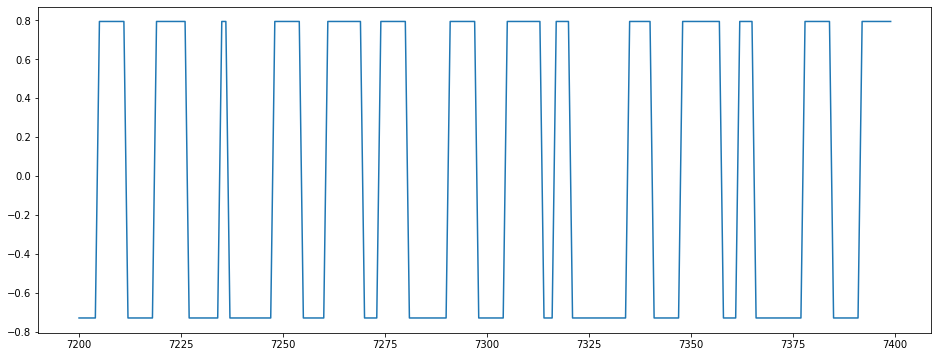

In [32]:
plt.plot(np.arange(7200, 7400, 1), speech1[7200:7400])
plt.show()

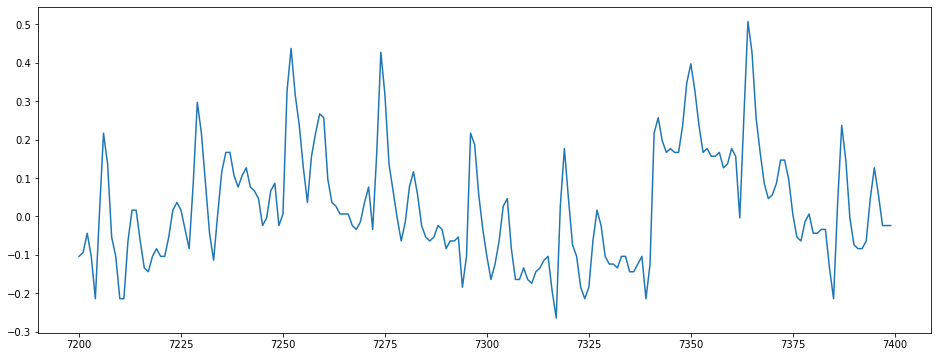

In [33]:
plt.plot(np.arange(7200, 7400, 1), music7[7200:7400])
plt.show()

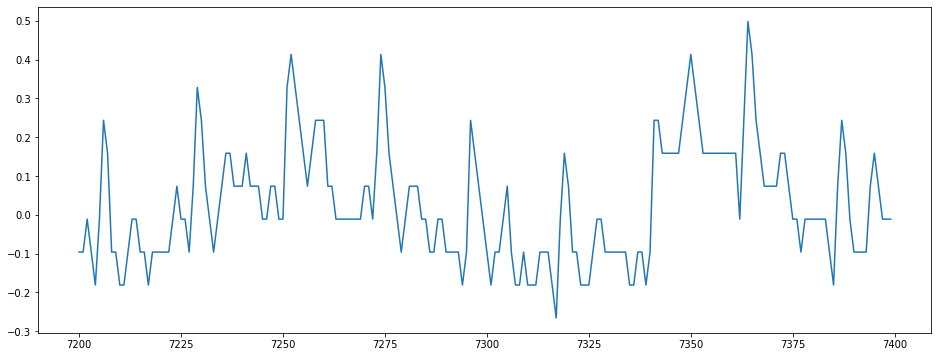

In [34]:
plt.plot(np.arange(7200, 7400, 1), music4[7200:7400])
plt.show()

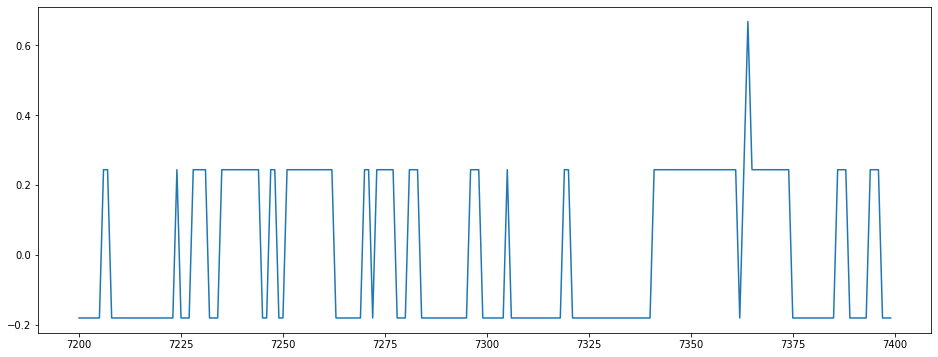

In [35]:
plt.plot(np.arange(7200, 7400, 1), music2[7200:7400])
plt.show()

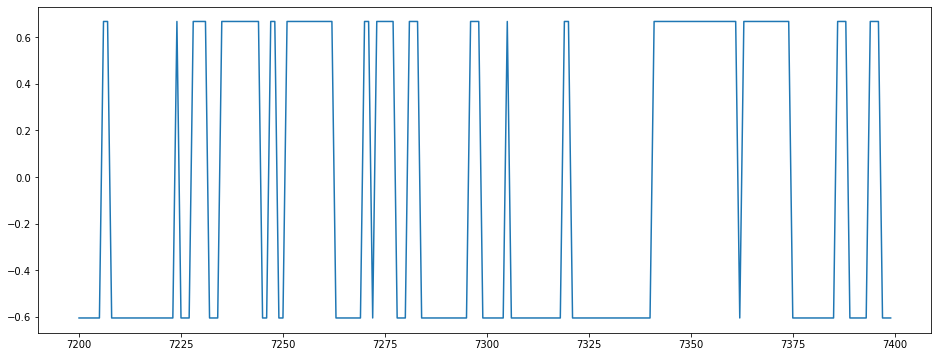

In [36]:
plt.plot(np.arange(7200, 7400, 1), music1[7200:7400])
plt.show()

<h3 style="color:red;"><left>Exercise 3.5. Error Analysis</left></h3>

As we have clearly observed, quantization produces errors in a signal. The most effective methods for analysis of the error turn out to be probabilistic. In order to apply these methods, however, one needs to have a clear understanding of the error signal’s statistical properties. For example, can we assume that the error signal is white noise? Can we assume that it is uncorrelated with the quantized signal? As you will see in this exercise, both of these are good assumptions if the quantization intervals are small compared with sample-to-sample variations in the signal.

If the original signal is $X$, and the quantized signal is $Y$, the error signal is defined by the following:

\begin{equation}
    E=Y-X
\end{equation}

**1. Compute the error signal for the quantized speech for $7$, $4$, $2$ and $1$ b/sample.**

In [37]:
error7 = speech7 - speech
error4 = speech4 - speech
error2 = speech2 - speech
error1 = speech1 - speech

---

When the spacing, $\Delta$, between quantization levels is sufficiently small, a common statistical model for the error is a uniform distribution from $-\frac{\Delta}{2}$ to $\frac{\Delta}{2}$.

**2. Use the command [```plt.hist(E, bins=20)```](https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.pyplot.hist.html) to generate 20-bin histograms for each of the four error signals.**

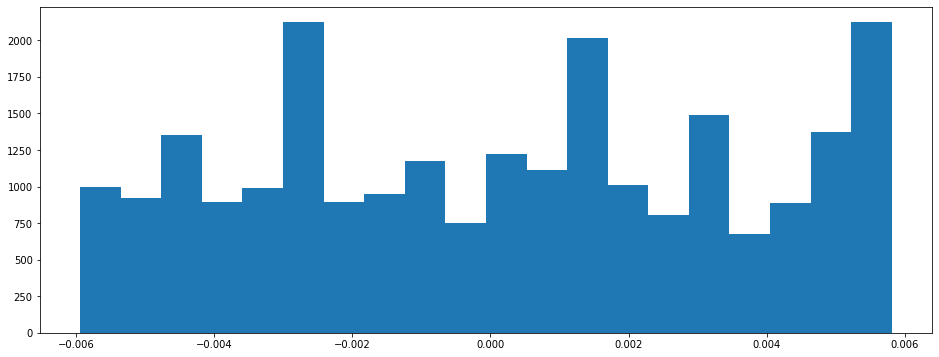

In [38]:
plt.hist(error7, bins=20)
plt.show()

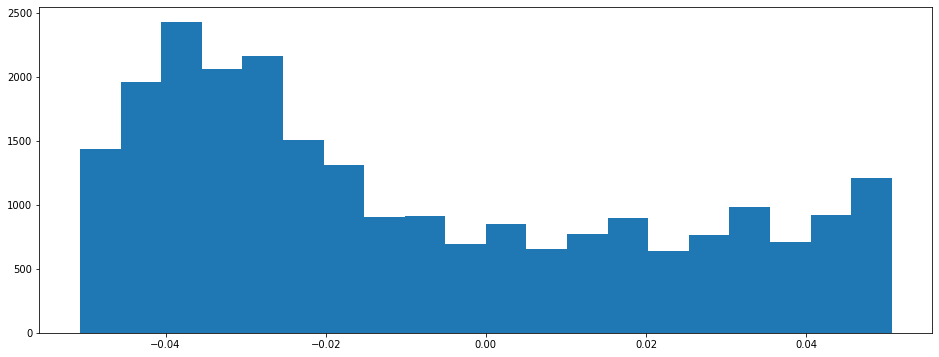

In [39]:
plt.hist(error4, bins=20)
plt.show()

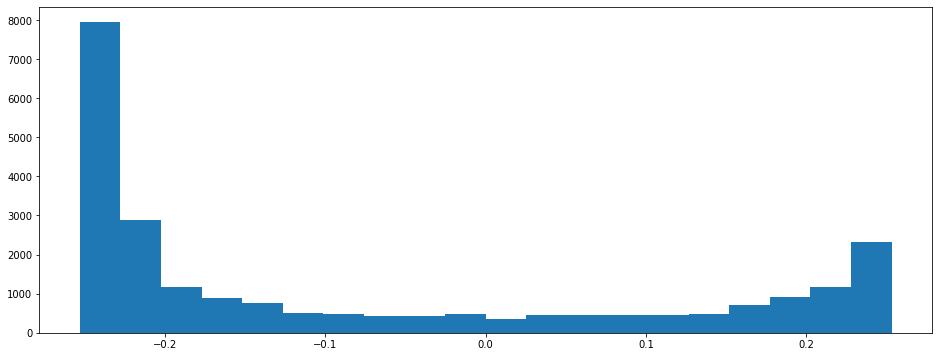

In [40]:
plt.hist(error2, bins=20)
plt.show()

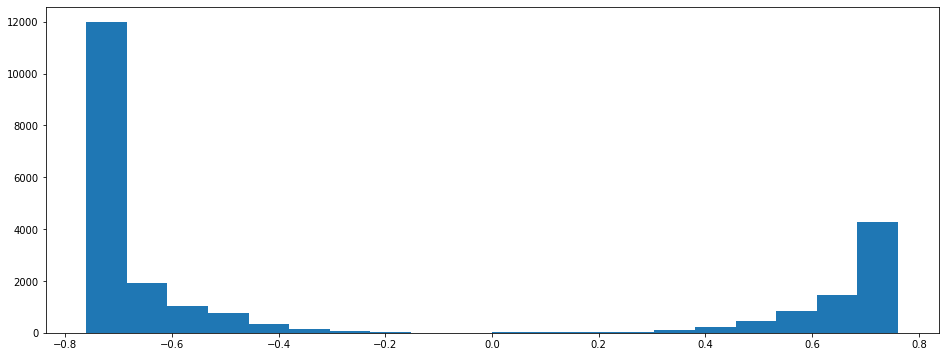

In [41]:
plt.hist(error1, bins=20)
plt.show()

**3. How does the number of quantization levels seem to affect the shape of the distribution?**

insert your answer here

**4. Explain why the error histograms you obtain might not be uniform?**

insert your answer here

---

Next we will examine correlation properties of the error signal.

**5. Compute and plot an estimate of the autocorrelation function for each of the four error signals using the following commands:**
```python
lags, r = xcorr(E, maxlags=200)
plt.plot(lags, r)
plt.show()
```
**Hint:** function ```xcorr``` is provided in the file ```helper.py```

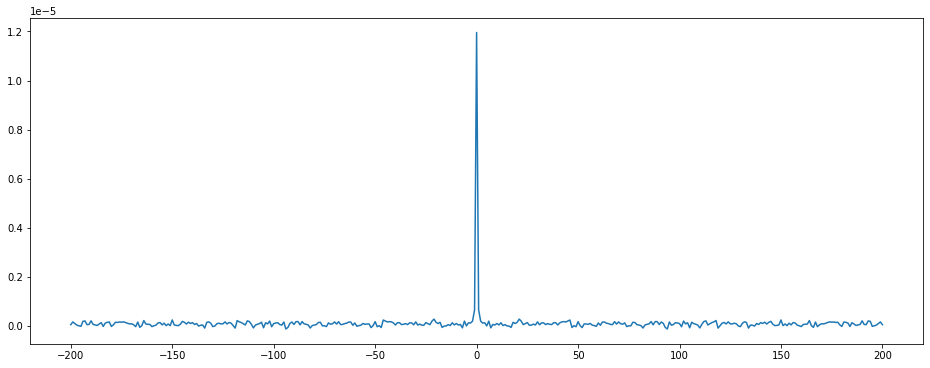

In [42]:
lags, r7 = xcorr(error7, error7, 200)
plt.plot(lags, r7)
plt.show()

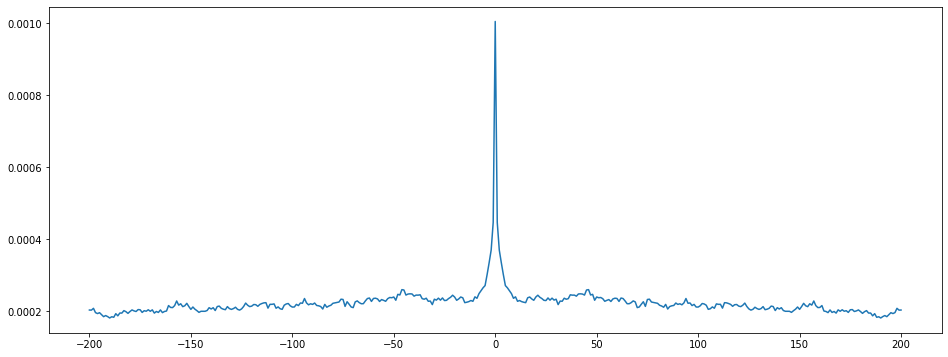

In [43]:
lags, r4 = xcorr(error4, error4, 200)
plt.plot(lags, r4)
plt.show()

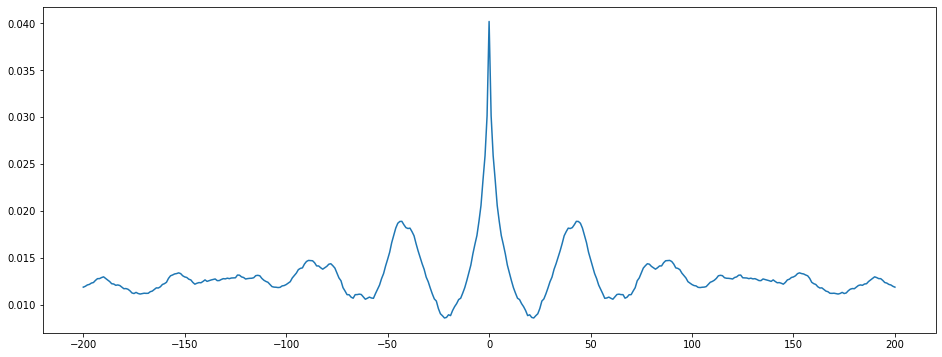

In [44]:
lags, r2 = xcorr(error2, error2, 200)
plt.plot(lags, r2)
plt.show()

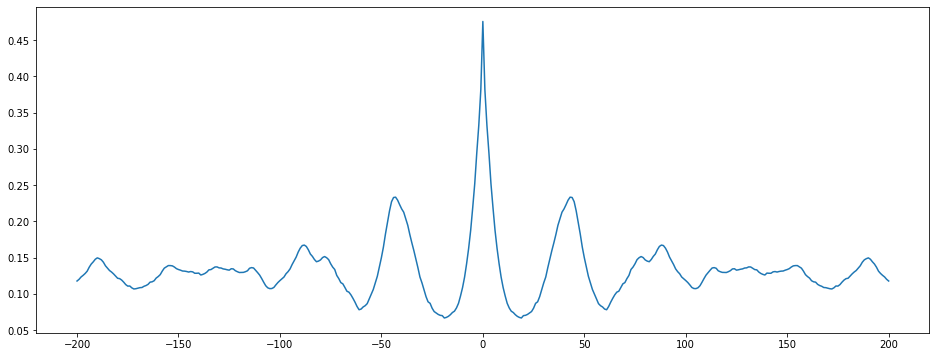

In [45]:
lags, r1 = xcorr(error1, error1, 200)
plt.plot(lags, r1)
plt.show()

**6. Now compute and plot an estimate of the cross-correlation function between the quantized speech $Y$ and each error signal $E$ using**
```python
lags, r = xcorr(E, Y, maxlags=200)
plt.plot(lags, r)
plt.show()
```
**Hint:** function ```xcorr``` is provided in the file ```helper.py```

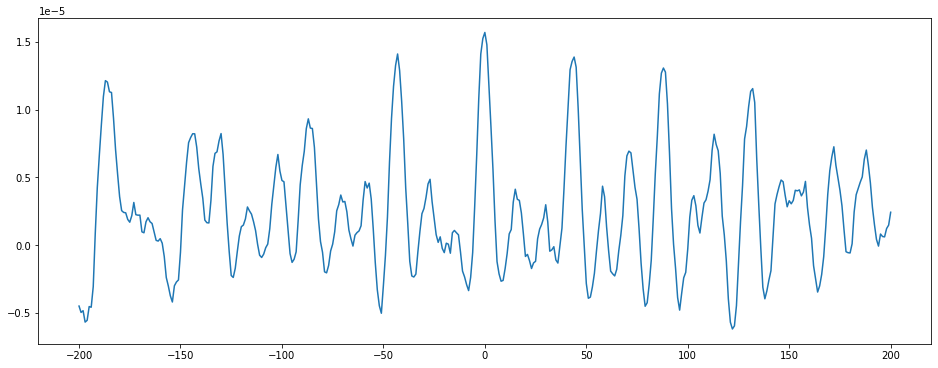

In [46]:
lags, r = xcorr(error7, speech7, maxlags=200)
plt.plot(lags, r)
plt.show()

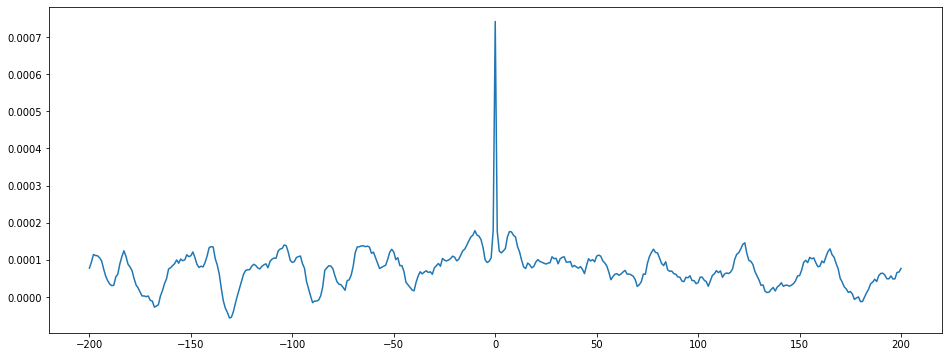

In [47]:
lags, r = xcorr(error4, speech4, maxlags=200)
plt.plot(lags, r)
plt.show()

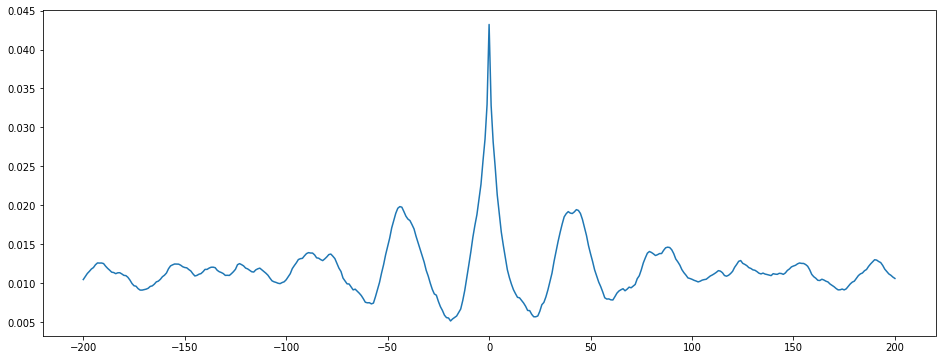

In [48]:
lags, r = xcorr(error2, speech2, maxlags=200)
plt.plot(lags, r)
plt.show()

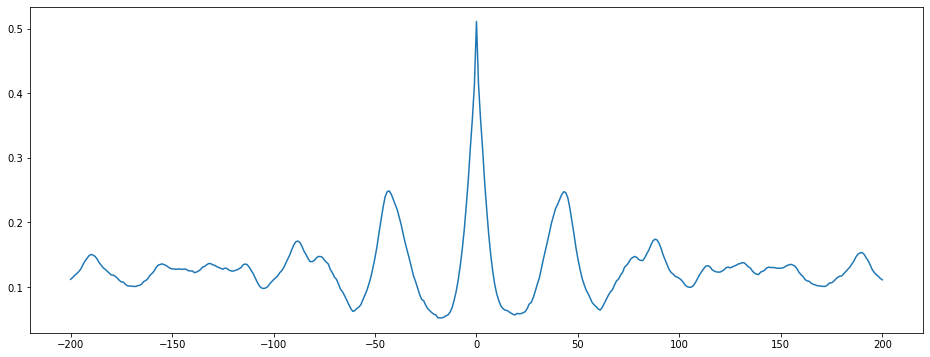

In [49]:
lags, r = xcorr(error1, speech1, maxlags=200)
plt.plot(lags, r)
plt.show()

**7. Is the autocorrelation influenced by the number of quantization levels? Do samples in the error signal appear to be correlated with each other?**

insert your answer here

**8. Does the number of quantization levels influence the cross-correlation?**

insert your answer here

<h3 style="color:red;"><left>Exercise 3.6: Signal to Noise Ratio</left></h3>

One way to measure the quality of a quantized signal is by the Power Signal-to-Noise Ratio (PSNR). This is defined by the ratio of the power in the quantized speech to power in the noise.

\begin{equation}
    \text{PSNR}=\frac{P_Y}{P_E}
\end{equation}

In this expression, the noise is the error signal $E$. Generally, this means that a higher PSNR implies a less noisy signal.

From previous labs we know the power of a sampled signal, $x[n]$, is defined by

\begin{align*}
    P_x=\frac{1}{L}\sum_{n=1}^Lx^2[n]
\end{align*}

where $L$ is the length of $x[n]$.

**1. Complete the function below that calculates the power of a sampled signal `x`.**

In [50]:
def get_power(x):
    """
    Parameters
    ---
    x: the input signal
    
    Returns
    ---
    P: the power of the signal
    """
    
    P = None
    return P

In [51]:
def get_power(x):
    return np.sum(x ** 2) / len(x)

**2. Compute the PSNR for the four quantized speech signals from the previous section.**

In [52]:
PSNR7 = get_power(speech7) / get_power(error7)
PSNR4 = get_power(speech4) / get_power(error4)
PSNR2 = get_power(speech2) / get_power(error2)
PSNR1 = get_power(speech1) / get_power(error1)
print("PSNR7: {}".format(PSNR7))
print("PSNR4: {}".format(PSNR4))
print("PSNR2: {}".format(PSNR2))
print("PSNR1: {}".format(PSNR1))

PSNR7: 1402.7704412544026
PSNR4: 17.170455479041895
PSNR2: 1.5692392618702706
PSNR1: 1.1846210894462874


---

In evaluating quantization (or compression) algorithms, a graph called a “rate-distortion curve” is often used. This curve plots **signal distortion vs. bit rate**. Here, we can measure the distortion by $\frac{1}{\text{PSNR}}$, and determine the bit rate from the number of quantization levels and sampling rate. For example, if the sampling rate is $8000$ samples/sec, and we are using $7$ bits/sample, the bit rate is $56$ kilobits/sec (kbps).

**3. Assuming that the speech is sampled at $8$kHz, plot the rate distortion curve using $\frac{1}{\text{PSNR}}$ as the measure of distortion. Generate this curve by computing the PSNR for $7, 6, 5,\dots, 1$ bits/sample. Make sure the axes of the graph are in terms of *distortion* and *bit rate*.**

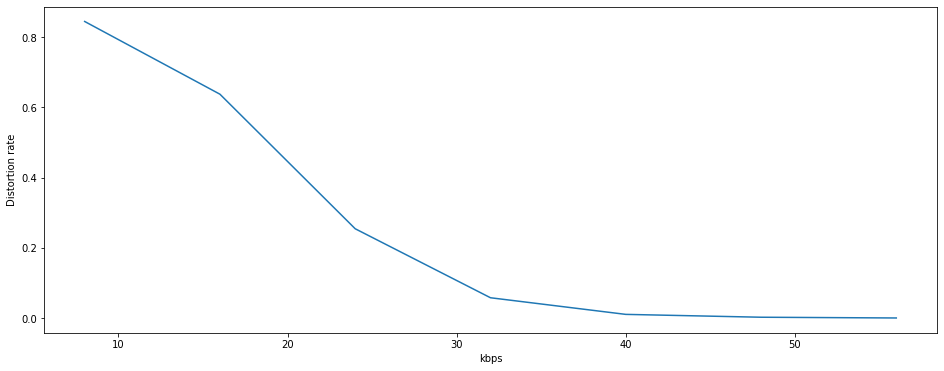

In [53]:
speech7 = Uquant(speech, 7)
speech6 = Uquant(speech, 6)
speech5 = Uquant(speech, 5)
speech4 = Uquant(speech, 4)
speech3 = Uquant(speech, 3)
speech2 = Uquant(speech, 2)
speech1 = Uquant(speech, 1)
error7 = speech7 - speech
error6 = speech6 - speech
error5 = speech5 - speech
error4 = speech4 - speech
error3 = speech3 - speech
error2 = speech2 - speech
error1 = speech1 - speech
PSNR7 = get_power(speech7) / get_power(error7)
PSNR6 = get_power(speech6) / get_power(error6)
PSNR5 = get_power(speech5) / get_power(error5)
PSNR4 = get_power(speech4) / get_power(error4)
PSNR3 = get_power(speech3) / get_power(error3)
PSNR2 = get_power(speech2) / get_power(error2)
PSNR1 = get_power(speech1) / get_power(error1)
PSNR = [1 / PSNR7, 1 / PSNR6, 1 / PSNR5, 1 / PSNR4, 1 / PSNR3, 1 / PSNR2, 1 / PSNR1]
plt.plot(np.arange(7, 0, -1) * 8, PSNR)
plt.xlabel("kbps")
plt.ylabel("Distortion rate")
plt.show()

<h3 style="color:salmon;"><left>3.7. Max Quantizer</left></h3>

In this section, we will investigate a different type of quantizer which produces less noise for a fixed number of quantization levels. As an example, let’s assume the input range for our signal is $[-1,1]$, but most of the input signal takes on values between $[-0.2, 0.2]$. If we place more of the quantization levels closer to zero, we can lower the average error due to quantization.

A common measure of quantization error is mean squared error (noise power). The **Max quantizer** is designed to minimize the mean squared error for a given set of training data. We will study how the Max quantizer works, and compare its performance to that of the uniform quantizer which was used in the previous sections.

<h4 style="color:salmon;"><left>Derivation</left></h4>

The Max quantizer determines quantization levels based on a data set’s probability density function, $f(x)$, and the number of desired levels, $N$. It minimizes the mean squared error between the original and quantized signals:

\begin{equation}
    \varepsilon=\sum_{k=1}^N\int_{x_k}^{x_{k+1}}(q_k-x)^2f(x)dx
\end{equation}

where $q_k$ is the $k^{\text{th}}$ quantization level, and $x_k$ is the lower boundary for $q_k$. The error $\varepsilon$ depends on both $q_k$ and $x_k$. (Note that for the Gaussian distribution, $x_1 = −\infty$, and $x_{N+1}=\infty$.) To minimize $\varepsilon$ with respect to $q_k$, we must take $\frac{\partial\varepsilon}{\partial q_k}=0$ and solve for $q_k$:

\begin{equation}
    q_k=\frac{\int_{x_k}^{x_{k+1}}xf(x)dx}{\int_{x_k}^{x_{k+1}}f(x)dx}\tag{1}
\end{equation}

We still need the quantization boundaries, $x_k$. Solving $\frac{\partial\varepsilon}{\partial x_k}=0$ yields

\begin{equation}
    x_k=\frac{q_{k-1}+q_k}{2}
\end{equation}

This means that each non-infinite boundary is exactly halfway in between the two adjacent quantization levels, and that each quantization level is at the centroid of its region. Figure 2 shows a five-level quantizer for a Gaussian distributed signal. Note that the levels are closer together in areas of higher probability.

<figure>
    <img src="imgs/figure2.png" style="width:60%">
    <em><center>Figure 2: Five level Max quantizer for Gaussian-distributed signal</center></em>
</figure>

<h4 style="color:salmon;"><left>Implementation, Error Analysis and Comparison</left></h4>

In this section we will write code to compute an optimal quantizer, and compare its performance to the uniform quantizer. Since we almost never know the actual probability density function of the data that the quantizer will be applied to, we cannot use equation (1) to compute the optimal quantization levels. Therefore, a numerical optimization procedure is used on a training set of data to compute the quantization levels and boundaries which yield the smallest possible error for that set.

A Python function `lloyds()` has been provided in the file `helper.py` that performs this optimization. It's syntax is

```python
partition, codebook = lloyds(training_set, initial_codebook)
```

This function requires two inputs. The first is the training dataset ```training_set```, from which it will estimate the probability density function. The second is a vector ```initial_codebook``` containing an initial guess of the optimal quantization levels. It returns the quantized signal ```quantized_signal```.

Since this algorithm minimizes the error with respect to the quantization levels, it is necessary to provice a decent initial guess of the codebook is necessary to help ensure a valid result. If the initial codebook is significantly “far” away from the optimal solution, it’s possible that the optimization will get trapped in a local minimum, and the resultant codebook may perform quite poorly. In order to make a good guess, we may first estimate the shape of the probability density function of the training set using a histogram. The idea is to divide the histogram into equal “areas” and choose quantization levels as the centers of each of these segments.

<h3 style="color:red;"><left>Exercise 3.8</left></h3>

**1. First plot a $40$-bin histogram of this speech signal using ```plt.hist(speech, bins=40)```, and make an initial guess of the four optimal quantization levels. Print out the histogram and the initial guess of the quantization levels.**

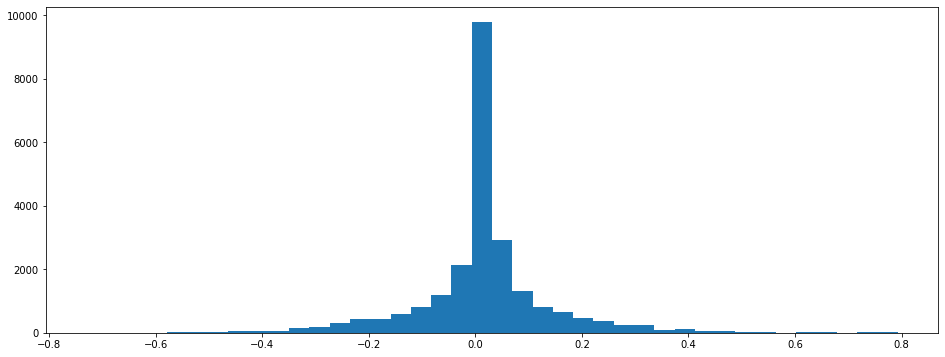

[-0.3, -0.1, 0.1, 0.3]


In [54]:
plt.hist(speech, bins=40)
plt.show()
initial_guess = [-0.3, -0.1, 0.1, 0.3]
print(initial_guess)

**2. Use the function ```lloyds()``` to compute an optimal $4$-level codebook using `speech.au` as the training set.**

In [55]:
partition, codebook = lloyds(speech, np.array(initial_guess))

**3. Once the optimal codebook is obtained, use the `codebook` and `partition` vectors to quantize the speech signal.**

* This may be done with a *for* loop and *if* statements.

In [56]:
quantized_speech = speech.copy()
for i in range(len(quantized_speech)):
    if quantized_speech[i] < partition[0]:
        quantized_speech[i] = codebook[0]
    elif quantized_speech[i] < partition[1]:
        quantized_speech[i] = codebook[1]
    elif quantized_speech[i] < partition[2]:
        quantized_speech[i] = codebook[2]
    else:
        quantized_speech[i] = codebook[3]

**4. Compute the error signal and PSNR.**

In [57]:
error = speech - quantized_speech
PSNR = get_power(quantized_speech) / get_power(error)
print("PSNR using max-quantizer: {:.4f}".format(PSNR))

PSNR using max-quantizer: 4.5983


**5. Plot the histogram in Q1 again. However, on this histogram plot, also mark where the optimal quantization levels fall along the $x$-axis.**

* To draw a vertical line, use `plt.axvline(x=0.8, color='r')` to plot a vertical line $x=0.8$ of red color.

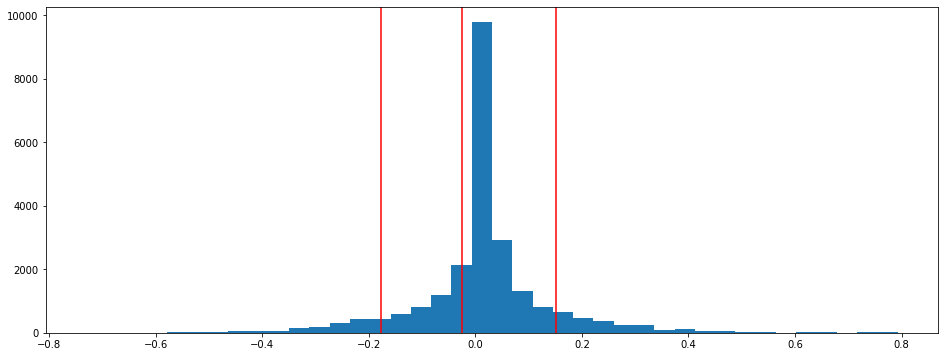

In [58]:
plt.hist(speech, bins=40)
plt.axvline(x=partition[0], color='r')
plt.axvline(x=partition[1], color='r')
plt.axvline(x=partition[2], color='r')
plt.show()

**6. Play the quantized audio, and compare the sound quality of the uniform- and max-quantized signals.**

In [59]:
ipd.Audio(quantized_speech, rate=8000)

**7. If the speech signal was uniformly distributed, would the two quantizers be the same? Explain your answer.**

insert your answer here